# Alpha Zero


AlphaZero learns purely from self-play using a single neural network that outputs both a **policy** (move probabilities) and a **value** (win chance). At decision time it runs **Monte-Carlo Tree Search (MCTS)** guided by that network; during training it updates the network to match the MCTS-improved policy and the eventual game outcome. It uses no handcrafted heuristics-just search-augmented learning-yielding strong play in perfect-information games, but with higher compute and slower per-move inference due to MCTS.


| Aspect | AlphaZero | DQN | PPO |
|---|---|---|---|
| Learning style | Self-play; trains a policy-value net to match **MCTS visit counts** (policy) + **final result** (value) | Off-policy **value-based** Q-learning with replay buffer + target network | On-policy **policy-gradient** with clipped objective; learns a stochastic policy and value function |
| Planning at inference | **Yes** (MCTS every move) | **No** (model-free) | **No** (model-free) |
| Data efficiency | High-quality/self-generated but compute-heavy | Good via replay; can be unstable in self-play | Needs fresh rollouts; stable updates via clipping |
| Inference speed | Slower (search per move) | Fast | Fast |
| Best fit | Perfect-information board games where search pays off | Discrete, reactive control (e.g., Atari), curricula with replay | Continuous/large action spaces; robust/steady improvement needs |


* **AlphaZero:** Likely strongest final strength; heavier training/inference compute and slower moves due to MCTS.  
* **DQN:** Very fast at inference; benefits from curriculum and opponent mixing, but no built-in lookahead.  
* **PPO:** Smooth/stable training with entropy and clipping; also benefits from curricula; no search at inference.


* 0.1 start
* 0.2 load from chkpt

In [1]:
# Reproducibility
def set_seed(seed: int = 666):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [2]:
# === AlphaZero Connect-4 - Notebook Scaffold (Step 1) ===

# Core imports
import os, sys, math, time, random
from dataclasses import dataclass
from typing import Callable, Optional, Tuple, List, Dict
import time
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

# Pretty prints (optional)
import pprint
pp = pprint.PrettyPrinter(indent=2, width=100)

# Project constants
BOARD_H, BOARD_W, ACTIONS = 6, 7, 7   # Connect-4
set_seed(666)

# Device & matmul precision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    torch.set_float32_matmul_precision("high")  # PyTorch 2.x
except Exception:
    pass

# CuDNN flags: comment these two for maximum speed (less determinism)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}  |  Torch: {torch.__version__}")

Device: cuda
CUDA available: True  |  Torch: 2.5.1


In [3]:
from A0.az_env import EnvAdapter
from A0.a0_utilities import state_encoder, legal_mask_from_board
from A0.az_net import AZNet
from A0.a0_mcts import MCTS
from A0.a0_selfplay import play_game
from A0.a0_buffer import ReplayBuffer
from A0.a0_train import AZTrainer
import A0.a0_config as C
from A0.a0_loop import selfplay_cycle, train_cycle
from A0.a0_eval import eval_vs_random, eval_vs_l1
from A0.a0_runner import run_training

print("All imports OK")

All imports OK


In [4]:
env = EnvAdapter(state_encoder=state_encoder)
model = AZNet().to(device).eval()   
mcts  = MCTS(model, EnvAdapter(state_encoder=state_encoder), sims=128, c_puct=2.0, device=device)
buffer = ReplayBuffer(capacity=C.REPLAY_CAPACITY)
trainer= AZTrainer(model, lr=C.LR, weight_decay=C.WEIGHT_DECAY, grad_clip=C.GRAD_CLIP, device=device, use_amp=C.USE_AMP)

C:\Users\Uporabnik\Documents\JS\Connect4\Code\Jupiter\Connect4\A0\a0_ckpt.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pkg = torch.load(path, map_location=device or 

[resume] loaded 'BEGIN.pt' | meta={'format': 'A0-CKPT-v1'} | buffer_len=0


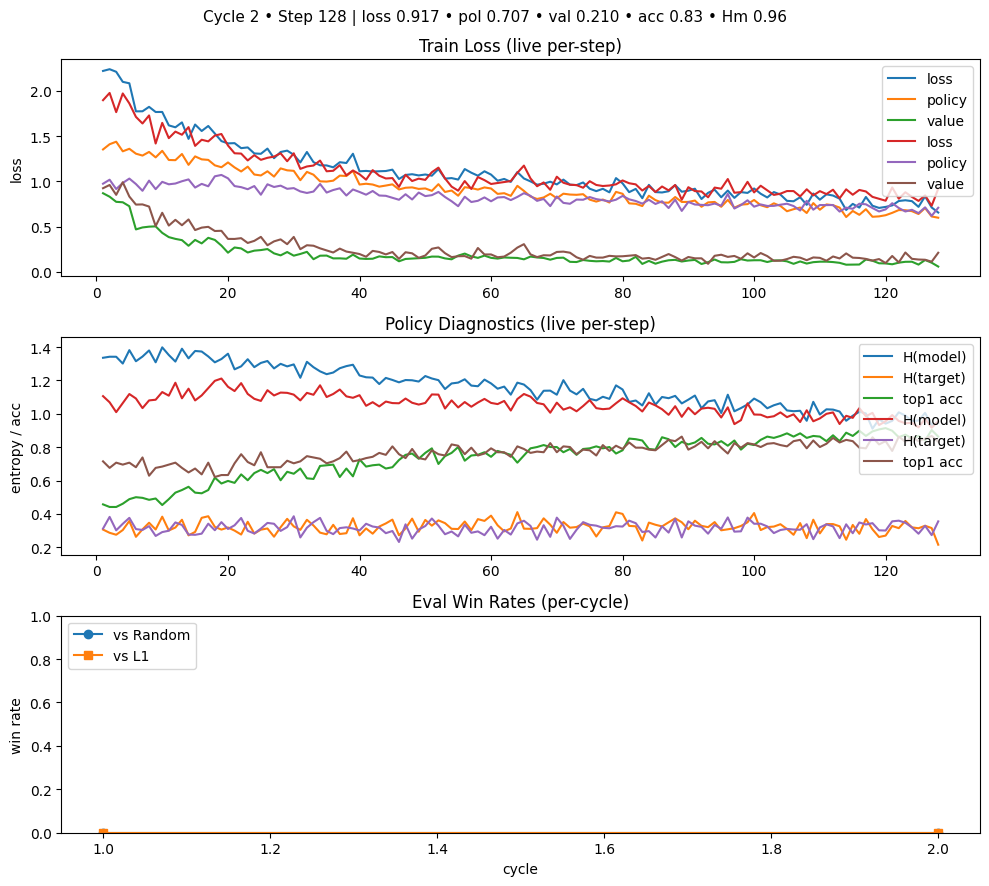

Cycles:   0%|          | 0/2 [00:00<?, ?it/s]


Self-play (cycle 1/2): 100%|██████████| 32/32 [10:06<00:00, 19.72s/it, D=4, L=17, W=11, avg_moves=36.9]
                                                                                                       
Train (cycle 1/2): 100%|██████████| 128/128 [00:43<00:00,  2.81it/s, Hm=0.95, acc=0.86, loss=0.655, pol=0.597, val=0.057]
                                                                                                                         
Self-play (cycle 2/2): 100%|██████████| 32/32 [12:38<00:00, 24.00s/it, D=1, L=12, W=19, avg_moves=37.5]
                                                                                                       
Train (cycle 2/2): 100%|██████████| 128/128 [00:47<00:00,  2.67it/s, Hm=0.96, acc=0.83, loss=0.917, pol=0.707, val=0.210]
                                                                                                                         

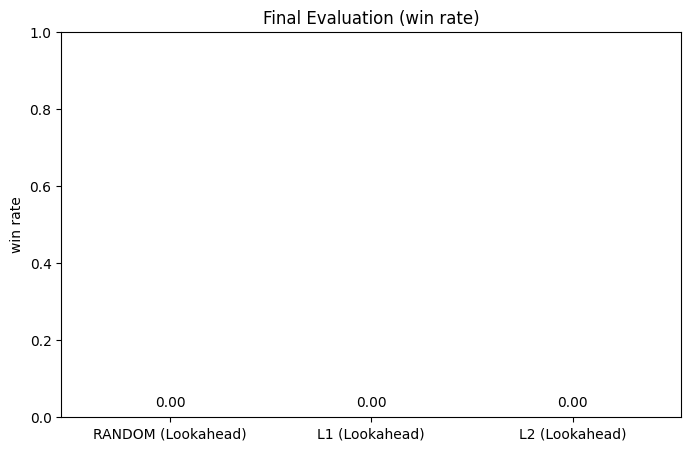

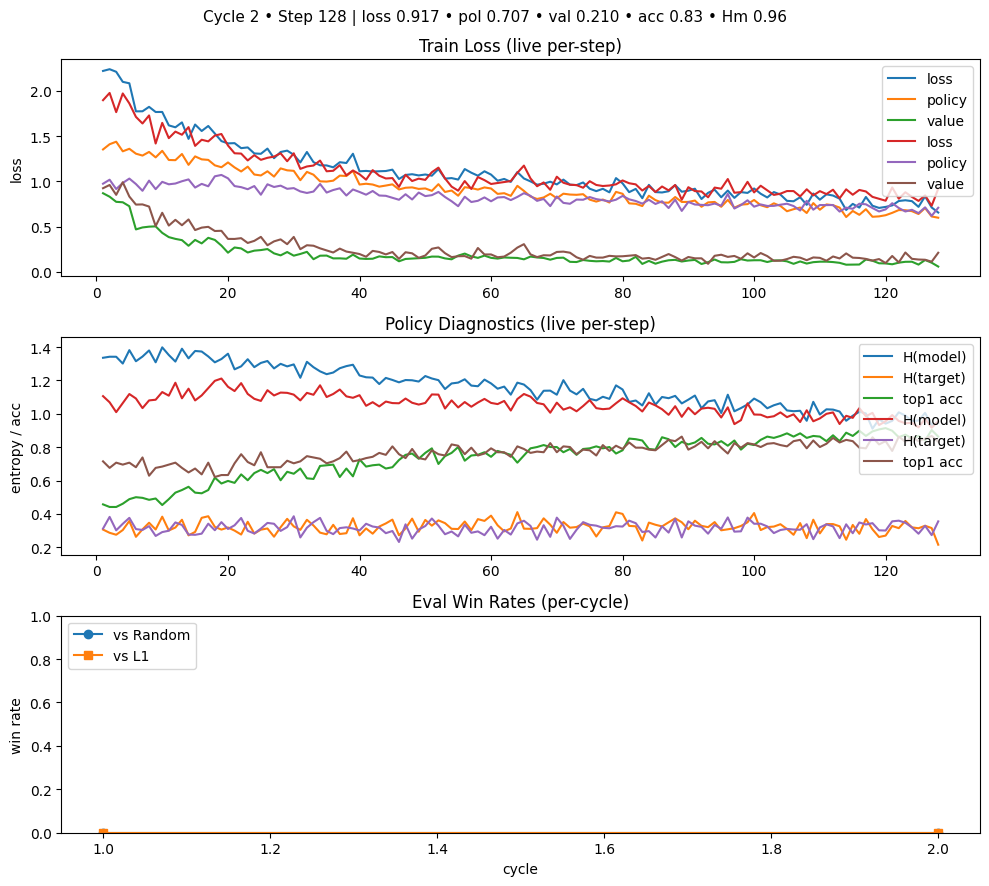

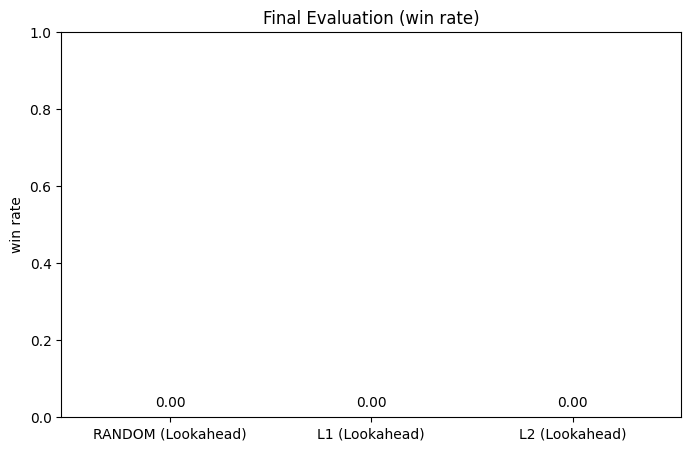

In [5]:
start_time = time.time()
result = run_training(out_dir="Logs/A0", max_cycles=12, eval_every=2, ckpt_every=2, final_eval=True,
                     resume_ckpt="CONTINUE.pt",    # <-- path to your saved ckpt
                    resume_load_buffer=True,                     # restores replay buffer (closer to seamless continuation)
                    resume_strict=True,                          # strict state_dict load (leave True unless you changed the net))
                     )
end_time = time.time()
elapsed = (end_time - start_time) / 60

In [6]:
print(f"\nTraining completed in {elapsed:.1f} minutes")


Training completed in 33.3 minutes


In [7]:
print(result)

{'out_dir': 'Logs/A0', 'xlsx': 'Logs/A0\\logs.xlsx', 'resume_meta': {'format': 'A0-CKPT-v1'}, 'start_cycle': 1, 'end_cycle': 2, 'final': [{'opponent': 'RANDOM (Lookahead)', 'games': 20, 'sims': 256, 'W': 0, 'L': 20, 'D': 0, 'win_rate': 0.0, 'loss_rate': 1.0, 'draw_rate': 0.0, 'W_as_P1': 0, 'L_as_P1': 10, 'D_as_P1': 0, 'W_as_P2': 0, 'L_as_P2': 10, 'D_as_P2': 0}, {'opponent': 'L1 (Lookahead)', 'games': 20, 'sims': 256, 'W': 0, 'L': 20, 'D': 0, 'win_rate': 0.0, 'loss_rate': 1.0, 'draw_rate': 0.0, 'W_as_P1': 0, 'L_as_P1': 10, 'D_as_P1': 0, 'W_as_P2': 0, 'L_as_P2': 10, 'D_as_P2': 0}, {'opponent': 'L2 (Lookahead)', 'games': 20, 'sims': 256, 'W': 0, 'L': 20, 'D': 0, 'win_rate': 0.0, 'loss_rate': 1.0, 'draw_rate': 0.0, 'W_as_P1': 0, 'L_as_P1': 10, 'D_as_P1': 0, 'W_as_P2': 0, 'L_as_P2': 10, 'D_as_P2': 0}]}
